In [1]:
from datetime import datetime
from deep_BN import ConvNet
from datasetADNI import AdniImagesDataset
from dataloaderADNI import get_kfCV_loaders, split_train_test
from hooks import get_all_layers, visualization
from stats import calc_intresting_statistics
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix
from scipy import stats, ndimage

import seaborn as sns
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from timeit import default_timer as timer

# device config
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
# which model we running here
NAME = "deep_BN"
# cv parameter
k_cv = 5
# params for dataset and loader
num_workers = 16
n_classes = 3
# hyper params.
n_epochs = 100
batch_size = 2
lr = 0.0001

# Reduced data set (1 scan per subject) set this parameter to True. If full dataset is wished to be used set this to False 
unique_subjects=True
if unique_subjects:
    PATH_TO_FIGS = "figs_reduced_data"
    PATH_TO_MODELS = "models_reduced_data"
    PATH_TO_LOGS = "logs_reduced"
else:
    PATH_TO_FIGS = "figs"
    PATH_TO_MODELS = "models"
    PATH_TO_LOGS = "logs"

In [3]:
#transform = transforms.Compose([transforms.ToTensor()])
dataset = AdniImagesDataset("../data_balanced", unique_subjects=unique_subjects)
train_dataset, test_dataset = split_train_test(dataset, n_classes=n_classes, test_ratio=0.2)
print(f"train_dataset = {len(train_dataset)}, test_dataset = {len(test_dataset)}")

Classes = {'AD': 0, 'MCI': 1, 'CN': 2}
Counts = {'AD': 112, 'MCI': 112, 'CN': 112}
train_dataset = 270, test_dataset = 66


In [4]:
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model)

ConvNet(
  (pool_stride_2): MaxPool3d(kernel_size=(2, 2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool_stride_1): MaxPool3d(kernel_size=(2, 2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
  (droput_3d_05): Dropout3d(p=0.5, inplace=False)
  (droput_1d_02): Dropout(p=0.25, inplace=False)
  (conv1): Conv3d(1, 5, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
  (relu1): ReLU()
  (bn1): BatchNorm3d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv3d(5, 5, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
  (relu2): ReLU()
  (bn2): BatchNorm3d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv3d(5, 5, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (relu3): ReLU()
  (bn3): BatchNorm3d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv3d(5, 5, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (relu4): ReLU()
  (bn4): BatchNo

In [5]:
######
## Run this cell for k-fold CV
######
writer_path = f"./{PATH_TO_LOGS}/{datetime.now().strftime('%Y%m%d-%H%M%S')}/"
writer_train_path = writer_path + f"{NAME}_train_batchSize_{batch_size}/"
writer_val_path = writer_path + f"{NAME}_validation_batchSize_{batch_size}/"

l1 = {0:[], 49:[], 99:[]}
l10 = {0:[], 49:[], 99:[]}
l19 = {0:[], 49:[], 99:[]}

feat_map1 = {0:None, 49:None, 99:None}
feat_map12 = {0:None, 49:None, 99:None}

all_predicted = []
all_true = []
aggregate_stats = []
best_val_acc = 0.0

# Lists holds aggregated info for each cv
train_acc = [np.zeros(k_cv) for i in range(n_epochs)]
train_loss = [np.zeros(k_cv) for i in range(n_epochs)]
val_acc = [np.zeros(k_cv) for i in range(n_epochs)]
val_loss = [np.zeros(k_cv) for i in range(n_epochs)]

## Go through all cv-partitions
for n_cv in range(k_cv):
    model = ConvNet().to(device)
    if n_cv == k_cv-1:
        get_all_layers(model) ## adding hooks to all layers. But only for one of the models, due to hardware performance.
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_loader, val_loader = get_kfCV_loaders(train_dataset, n_classes=n_classes, k=0.245, batch_size=batch_size, num_workers=num_workers)
    
    
    n_train_samples = len(train_loader.dataset)
    n_val_samples = len(val_loader.dataset)
    
    ## go through n epochs per k-fold cv
    for epoch in range(n_epochs):
        print(f'CV: [{n_cv+1}]/[{k_cv}], Epoch: [{epoch+1}/{n_epochs}]', end='\r')
        tmp_train_loss = 0
        tmp_train_corr = 0
        tmp_val_loss = 0
        tmp_val_corr = 0
        
        ### Training
        model.train()
        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            # forward
            outputs = model(imgs)
            loss = criterion(outputs, labels)            

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tmp_train_loss +=  loss.item()
            _, predicted = torch.max(outputs.data, 1)
            tmp_train_corr += (predicted==labels).sum().item()
            
        train_acc[epoch][n_cv] = 100 * tmp_train_corr/n_train_samples
        train_loss[epoch][n_cv] = tmp_train_loss/n_train_samples
        
        if epoch in [0, 49, 99]:
            l1[epoch].extend( model.conv1.weight.grad.flatten().cpu().detach().tolist() )
            l10[epoch].extend( model.conv10.weight.grad.flatten().cpu().detach().tolist() )
            l19[epoch].extend( model.fc3.weight.grad.flatten().cpu().detach().tolist() )
            if n_cv == k_cv-1: 
                feat_map1[epoch] = visualization["conv1"][0]
                feat_map12[epoch] = visualization["conv12"][0]
        #writer_train.add_scalar('loss', train_running_loss / n_train_samples, epoch)
        #writer_train.add_scalar('accuracy', 100 * train_running_acc / n_train_samples, epoch)
        
        
        ### Validation
        model.eval()
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device)
                labels = labels.to(device)

                # forward
                outputs = model(imgs)
                loss = criterion(outputs, labels)

                tmp_val_loss +=  loss.item()
                _, predicted = torch.max(outputs.data, 1)
                tmp_val_corr += (predicted==labels).sum().item()
                
                if epoch == (n_epochs-1): ## last epoch, acquire stats
                    all_true.extend(labels)
                    all_predicted.extend(predicted)
                
            val_acc[epoch][n_cv] = 100 * tmp_val_corr/n_val_samples
            val_loss[epoch][n_cv] = tmp_val_loss/n_val_samples
            
            if epoch == (n_epochs-1): ## last epoch, acquire stats
                aggregate_stats.append(calc_intresting_statistics(all_true, all_predicted, [0,1,2]))
                if val_acc[epoch][n_cv] > best_val_acc:
                    best_val_acc = val_acc[epoch][n_cv]
                    torch.save(model.state_dict(), f"{PATH_TO_MODELS}/{NAME}/eval_grads_CNN_batchSize_{batch_size}")
                
            #writer_val.add_scalar('loss', val_running_loss / n_val_samples, epoch)
            #writer_val.add_scalar('accuracy', 100 * val_running_acc / n_val_samples, epoch)

## Val acc of best model
print(f"Best model val acc: {best_val_acc}")

## Statistics
t = 2.776  # 95% confidence interval, t-value. d.f. = n-1 = 5-1 = 4 
train_interval_acc = []
val_interval_acc = []

train_interval_loss = []
val_interval_loss = []

train_mean_acc = []
val_mean_acc = []

train_mean_loss = []
val_mean_loss = []

for epoch in range(n_epochs):
    train_interval_acc.append( t * np.std(train_acc[epoch], ddof=1) / (len(train_acc[epoch])**0.5) )
    val_interval_acc.append( t * np.std(val_acc[epoch], ddof=1) / (len(val_acc[epoch])**0.5) )
    
    train_interval_loss.append( t * np.std(train_loss[epoch], ddof=1) / (len(train_loss[epoch]))**0.5 )
    val_interval_loss.append( t * np.std(val_loss[epoch], ddof=1) / (len(val_loss[epoch]))**0.5 )
    
    train_mean_acc.append( np.mean(train_acc[epoch]) )
    val_mean_acc.append( np.mean(val_acc[epoch]) )
    
    train_mean_loss.append( np.mean(train_loss[epoch]) )
    val_mean_loss.append( np.mean(val_loss[epoch]) )

## Write to tensorboard logs
writer_train = SummaryWriter(writer_train_path)
writer_val = SummaryWriter(writer_val_path)

for epoch, (ta, tl, va, vl) in enumerate(zip(train_mean_acc, train_mean_loss, val_mean_acc, val_mean_loss)):
    writer_train.add_scalar('accuracy', ta, epoch)
    writer_train.add_scalar('loss', tl, epoch)
    writer_val.add_scalar('accuracy', va, epoch)
    writer_val.add_scalar('loss', vl, epoch)

writer_train.close()
writer_val.close()

train_interval_acc = np.array(train_interval_acc)
val_interval_acc = np.array(val_interval_acc)
train_interval_loss = np.array(train_interval_loss)
val_interval_loss = np.array(val_interval_loss)

train_mean_acc = np.array(train_mean_acc)
val_mean_acc = np.array(val_mean_acc)
train_mean_loss = np.array(train_mean_loss)
val_mean_loss = np.array(val_mean_loss)

Best model val acc: 39.39393939393939


In [6]:
import json
stats_CI = {}
for c_name in ["AD", "MCI", "CN"]:
    stats_CI[c_name] = {}
    for s in ['Precision', 'Sensitivity', 'Specificity', 'FPR', 'FNR']:
        stats_CI[c_name][s] = []

for (c_name, c) in zip(["AD", "MCI", "CN"], [0,1,2]):
    for dicts in aggregate_stats:
        for s in ['Precision', 'Sensitivity', 'Specificity', 'FPR', 'FNR']:
            stats_CI[c_name][s].append(dicts[c][s])

## Statistics
stats_CI_95 = {}
t = 2.776  # 95% confidence interval, t-value. d.f. = n-1 = 5-1 = 4 
for c_name in ["AD", "MCI", "CN"]:
    stats_CI_95[c_name] = {}
    for s in ['Precision', 'Sensitivity', 'Specificity', 'FPR', 'FNR']: 
        stats_CI_95[c_name][s] = {"mean":np.mean(stats_CI[c_name][s]), "CI": t * np.std(stats_CI[c_name][s], ddof=1) / (len(stats_CI[c_name][s])**0.5)}

dict_file = open(f"{PATH_TO_FIGS}/{NAME}/{batch_size}/{NAME}_{batch_size}_stats_CI_95.json", "w")
json.dump(stats_CI_95, dict_file)
dict_file.close()

In [7]:
# Run this cell to test the model
test_loader =  torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers = num_workers)

model = ConvNet().to(device)
model.load_state_dict(torch.load(f"{PATH_TO_MODELS}/{NAME}/eval_grads_CNN_batchSize_{batch_size}"))
get_all_layers(model)

model.eval()
with torch.no_grad():
    n_samples = 0
    running_loss=0.0
    n_class_corr = [0 for i in range(3)]
    n_class_samples = [0 for i in range(3)]
    total_pred = []
    total_labels = []
    total_pred_score = []
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        # max returns (value, index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        running_loss += criterion(outputs, labels)
        total_pred.extend(predicted.cpu().detach().tolist())
        total_labels.extend(labels.cpu().detach().tolist())
        total_pred_score.extend(outputs.cpu().detach().numpy())
        
    for pred, label  in zip(total_pred, total_labels):
        if (label == pred):
            n_class_corr[label] += 1
        n_class_samples[label] += 1
        
    acc = 100 * np.sum(np.array(total_pred) == np.array(total_labels)) / n_samples
    print(f"Avarage test loss: {running_loss/n_samples}")
    print(f'Test Accuracy of the network: {acc}%')

    for i in range(3):
        acc = 100 * n_class_corr[i] / n_class_samples[i]
        print(f'Accuracy of {i}: {acc} %')
        
test_feat_map1 = visualization["conv1"][0]
test_feat_map12 = visualization["conv12"][0]

Avarage test loss: 0.6247941851615906
Test Accuracy of the network: 48.484848484848484%
Accuracy of 0: 18.181818181818183 %
Accuracy of 1: 45.45454545454545 %
Accuracy of 2: 81.81818181818181 %


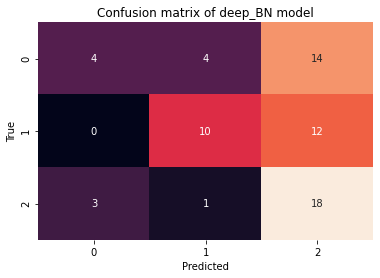

In [8]:
cf_matrix = confusion_matrix(total_labels, total_pred)

fig, ax = plt.subplots()
sns.heatmap(cf_matrix, annot=True, cbar=False, ax=ax)

ax.set_title(f'Confusion matrix of {NAME} model')
ax.set_ylabel("True")
ax.set_xlabel("Predicted")
plt.show()
fig.savefig(f"{PATH_TO_FIGS}/{NAME}/{batch_size}/cf_matrix_batchSize_{batch_size}.png", dpi=100)

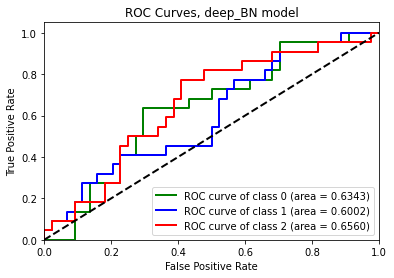

In [9]:
## ROC PLOT
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(nn.functional.one_hot(torch.as_tensor(total_labels))[:, i], np.array(total_pred_score)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fig = plt.figure()
colors = cycle(['green', 'blue', 'red'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.4f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves, {NAME} model')
plt.legend(loc="lower right")
plt.show()
fig.savefig(f"{PATH_TO_FIGS}/{NAME}/{batch_size}/ROCAUC_plot_batchSize_{batch_size}.png", dpi=100)

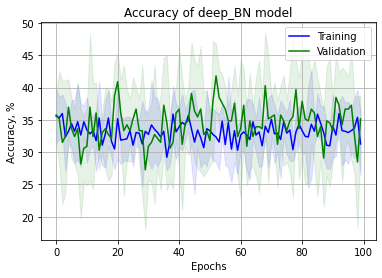

In [10]:
## Acc plot
fig, ax = plt.subplots()
ax.plot(list(range(n_epochs)), train_mean_acc, color='b', label="Training")
ax.fill_between(list(range(n_epochs)), np.clip((train_mean_acc-train_interval_acc) , a_min=0, a_max=100), np.clip((train_mean_acc+train_interval_acc) , a_min=0, a_max=100), color='b', alpha=.1)
ax.plot(list(range(n_epochs)), val_mean_acc, color='g', label="Validation")
ax.fill_between(list(range(n_epochs)), np.clip((val_mean_acc-val_interval_acc), a_min=0, a_max=100), np.clip((val_mean_acc+val_interval_acc), a_min=0, a_max=100), color='g', alpha=.1)
ax.set_ylabel("Accuracy, %")
ax.set_xlabel("Epochs")
ax.set_title(f"Accuracy of {NAME} model")
plt.grid()
plt.legend()
plt.show()
fig.savefig(f"{PATH_TO_FIGS}/{NAME}/{batch_size}/accuracy_plot_batchSize_{batch_size}.png", dpi=100)

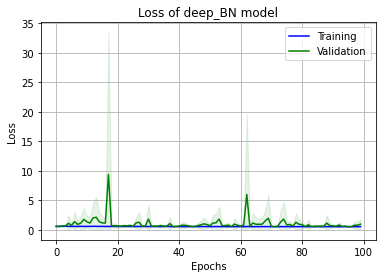

In [11]:
## Loss plot
fig, ax = plt.subplots()
ax.plot(list(range(n_epochs)), train_mean_loss, color='b', label="Training")
ax.fill_between(list(range(n_epochs)), np.clip((train_mean_loss-train_interval_loss), a_min=0, a_max=None), np.clip((train_mean_loss+train_interval_loss), a_min=0, a_max=None), color='b', alpha=.1)
ax.plot(list(range(n_epochs)), val_mean_loss, color='g', label="Validation")
ax.fill_between(list(range(n_epochs)), np.clip((val_mean_loss-val_interval_loss), a_min=0, a_max=None), np.clip((val_mean_loss+val_interval_loss), a_min=0, a_max=None), color='g', alpha=.1)
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
ax.set_title(f"Loss of {NAME} model")
plt.grid()
plt.legend()
plt.show()
fig.savefig(f"{PATH_TO_FIGS}/{NAME}/{batch_size}/loss_plot_batchSize_{batch_size}.png", dpi=300)

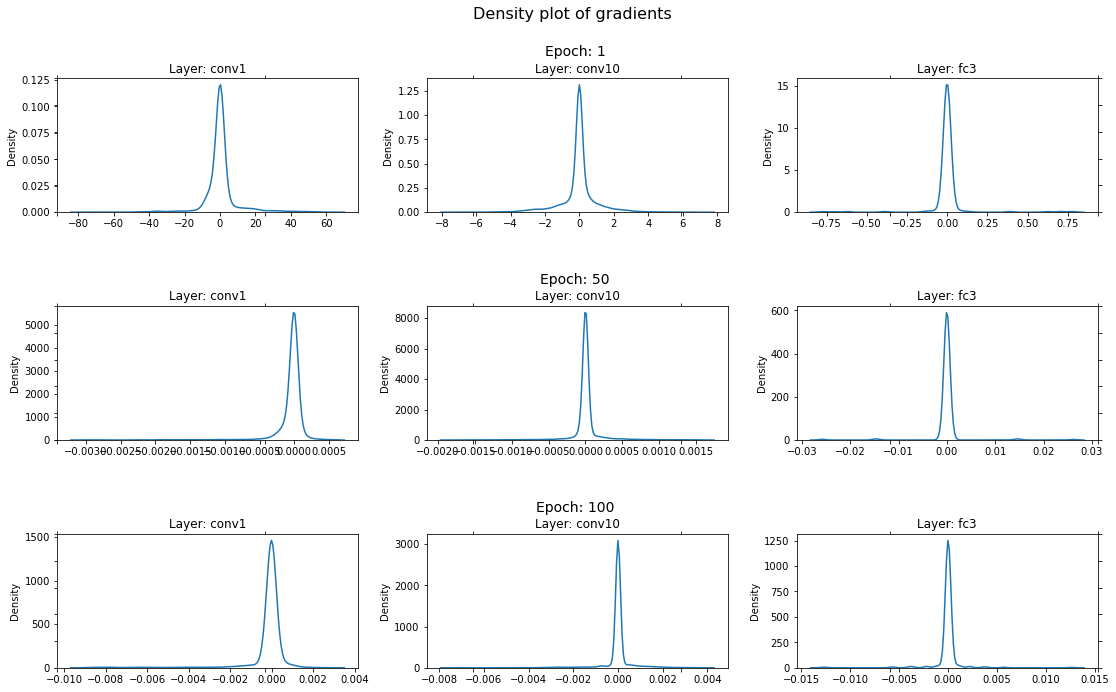

In [12]:
fig, big_axes = plt.subplots( figsize=(16, 10) , nrows=3, ncols=1, sharey=True) 
n_epoch = ["1","50","100"]
for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title("Epoch: %s \n" % n_epoch[row-1], fontsize=14)

    # Turn off axis lines and ticks of the big subplot 
    # obs alpha is 0 in RGBA string!
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False

l_name = ["conv1","conv10","fc3"]
for i, epoch in enumerate([0, 49, 99]):
    for j, layer  in enumerate([l1,l10,l19]):
        n_ax = i*3+j+1
        ax = fig.add_subplot(3,3,n_ax)
        ax.set_title("Layer: "+l_name[j], fontsize=12)
        sns.kdeplot(layer[epoch], ax=ax)

fig.set_facecolor('w')
fig.suptitle("Density plot of gradients", fontsize=16, x=0.5175)
plt.tight_layout()
plt.show()
fig.savefig(f"{PATH_TO_FIGS}/{NAME}/{batch_size}/gradients_density_plot_batchSize_{batch_size}.png", dpi=100)

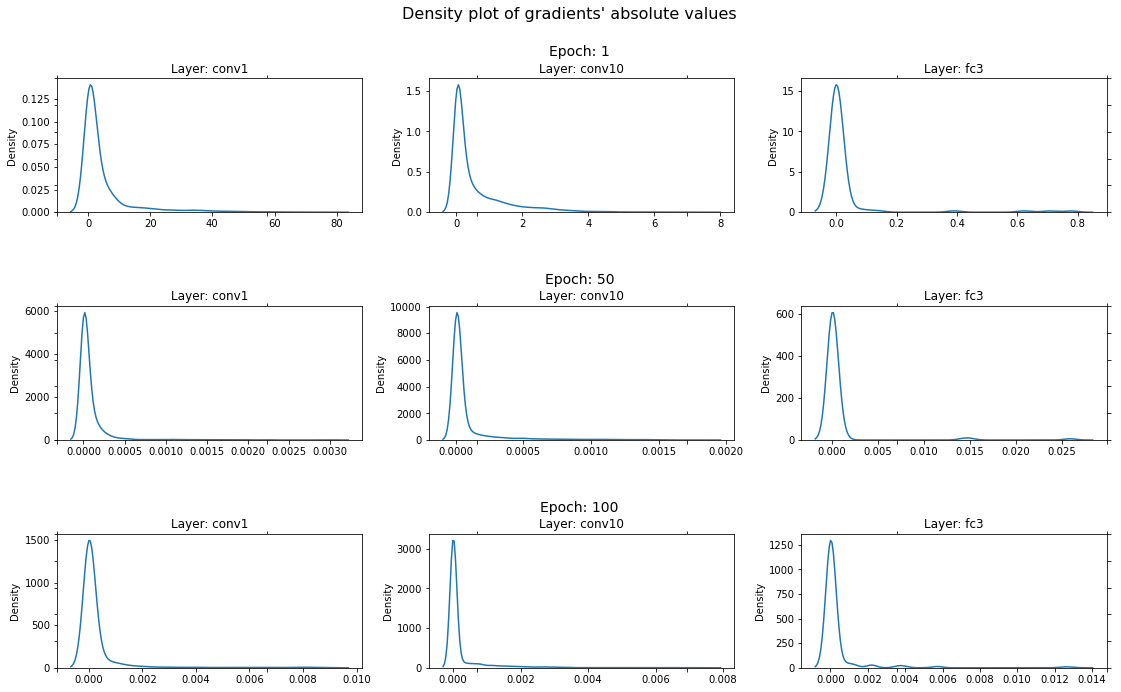

In [13]:
fig, big_axes = plt.subplots( figsize=(16, 10) , nrows=3, ncols=1, sharey=True) 
n_epoch = ["1", "50", "100"]
for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title("Epoch: %s \n" % n_epoch[row-1], fontsize=14)

    # Turn off axis lines and ticks of the big subplot 
    # obs alpha is 0 in RGBA string!
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False

l_name = ["conv1","conv10","fc3"]
for i, epoch in enumerate([0, 49, 99]):
    for j, layer  in enumerate([l1,l10,l19]):
        n_ax = i*3+j+1
        ax = fig.add_subplot(3,3,n_ax)
        ax.set_title("Layer: "+l_name[j], fontsize=12)
        sns.kdeplot(np.abs(layer[epoch]), ax=ax)

fig.set_facecolor('w')
fig.suptitle("Density plot of gradients' absolute values", fontsize=16, x=0.5175)
plt.tight_layout()
plt.show()
fig.savefig(f"{PATH_TO_FIGS}/{NAME}/{batch_size}/absolute_gradients_density_plot_batchSize_{batch_size}.png", dpi=100)

In [14]:
l_name = ["conv1","conv10","fc3"]
tmp_stat_str = ""
for epoch in [0, 49, 99]:
    tmp_stat_str += f"Epoch: {epoch+1}\n"
    for j, layer  in enumerate([l1,l10,l19]):
        tmp_stat_str += f"Layer:{l_name[j]}\n"
        tmp_stat_str += str(stats.describe(np.abs(layer[epoch])))+"\n\n"
    tmp_stat_str += "\n"

print(tmp_stat_str)
file = open(f"{PATH_TO_FIGS}/{NAME}/{batch_size}/stats_summary_batchSize_{batch_size}.txt", "w") 
file.write(tmp_stat_str) 
file.close() 

Epoch: 1
Layer:conv1
DescribeResult(nobs=3125, minmax=(1.030109388011624e-06, 78.17566680908203), mean=4.647207701124509, variance=86.39417350200804, skewness=3.51875852130588, kurtosis=14.510623473010401)

Layer:conv10
DescribeResult(nobs=13500, minmax=(2.1208443001796695e-08, 7.60380744934082), mean=0.5656808774546658, variance=0.8208730303464986, skewness=2.50175541950033, kurtosis=7.657347579225167)

Layer:fc3
DescribeResult(nobs=4000, minmax=(0.0, 0.7803192138671875), mean=0.027715242173271294, variance=0.014678412442200011, skewness=5.097707741013695, kurtosis=25.38452912829486)


Epoch: 50
Layer:conv1
DescribeResult(nobs=3125, minmax=(1.970413849444741e-12, 0.00306433136574924), mean=8.509553262700826e-05, variance=6.56477458097212e-08, skewness=6.494670460149293, kurtosis=50.65303972846639)

Layer:conv10
DescribeResult(nobs=13500, minmax=(4.440583371932011e-13, 0.0018630466656759381), mean=8.144194250468943e-05, variance=4.340779260204793e-08, skewness=4.022881822347098, kurtos

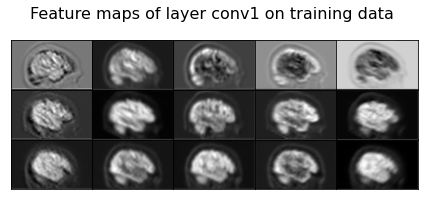

In [15]:
fig = plt.figure(figsize=(6, 2.75))
for i, epoch in enumerate([0, 49, 99]):
    for j, f in enumerate(feat_map1[epoch]):
        n_ax = i*5+j+1
        ax = fig.add_subplot(3, 5, n_ax)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(ndimage.rotate(f[48], 90), cmap='gray') ## rotating to make it look neat in our LaTeX template


#fig.set_facecolor('w')
fig.suptitle("Feature maps of layer conv1 on training data", fontsize=16)
fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
fig.show()

fig.savefig(f"{PATH_TO_FIGS}/{NAME}/{batch_size}/featureMaps_conv1_trainData_batchSize_{batch_size}.png", dpi=100)

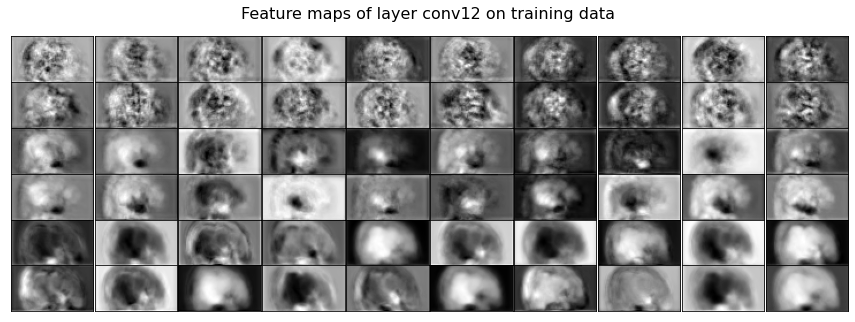

In [16]:
fig = plt.figure(figsize=(12, 4.5))
for i, epoch in enumerate([0, 49, 99]):
    for j, f in enumerate(feat_map12[epoch]):
        n_ax = i*20+j+1
        ax = fig.add_subplot(6, 10, n_ax)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(ndimage.rotate(f[14], 90), cmap='gray') ## rotating to make it look neat in our LaTeX template
        #ax.invert_yaxis()


#fig.set_facecolor('w')
fig.suptitle("Feature maps of layer conv12 on training data", fontsize=16)
fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

fig.savefig(f"{PATH_TO_FIGS}/{NAME}/{batch_size}/featureMaps_conv12_trainData_batchSize_{batch_size}.png", dpi=100)

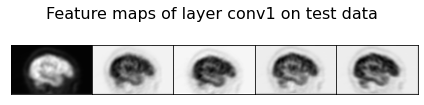

In [17]:
fig = plt.figure(figsize=(6, 1.45))
for j, f in enumerate(test_feat_map1):
    ax = fig.add_subplot(1, 5, j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(ndimage.rotate(f[48], 90), cmap='gray') ## rotating to make it look neat in our LaTeX template


#fig.set_facecolor('w')
fig.suptitle("Feature maps of layer conv1 on test data", fontsize=16)
fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
fig.show()

fig.savefig(f"{PATH_TO_FIGS}/{NAME}/{batch_size}/featureMaps_conv1_testData_batchSize_{batch_size}.png", dpi=100)

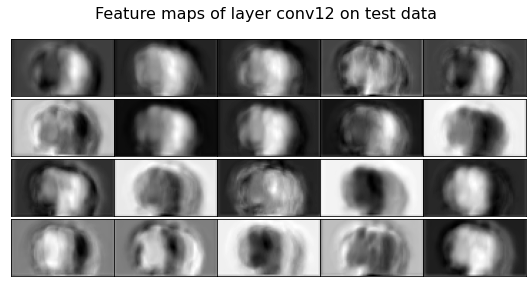

In [18]:
fig = plt.figure(figsize=(7.5, 4))
for j, f in enumerate(test_feat_map12):
    ax = fig.add_subplot(4, 5, j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(ndimage.rotate(f[14], 90), cmap='gray') ## rotating to make it look neat in our LaTeX template
    #ax.invert_yaxis()


#fig.set_facecolor('w')
fig.suptitle("Feature maps of layer conv12 on test data", fontsize=16)
fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

fig.savefig(f"{PATH_TO_FIGS}/{NAME}/{batch_size}/featureMaps_conv12_testData_batchSize_{batch_size}.png", dpi=100)


In [20]:
from captum.attr import LayerGradCam, LayerAttribution, visualization, GuidedGradCam
from matplotlib import cm
import cv2

def predict_label(scan, model=model):
    # Convert to a batch of 1
    xb = scan.unsqueeze(0)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    output = F.softmax(yb, dim=1)
    prediction_score, pred = torch.topk(output, 1)

    return pred.squeeze()

def min_max_norm(x): 
    max_val = np.max(x)
    min_val = np.min(x)
    y = (x-min_val) / (max_val-min_val)
    return y

In [20]:
## 0   1       2
width, height, depth = 160, 160, 96

# for plotting
grad_constraint = 0
alpha_plt_value = 0.4

## cases 14, 143 and 202
for test_scan_number in [0, 23, 44]:
    
    classes = {0:"AD", 1:"MCI", 2:"CN"} #sets all the classes

    scans, labels = test_dataset[test_scan_number] 
    case = classes[labels.item()]

    print(f"Scan is of class: {case}")

    layer_gc = LayerGradCam(model, model.conv19)
    input = scans.unsqueeze(0).clone().detach().cuda().requires_grad_(True)

    #Detta måste upsamplas! (GRADCAM)
    #attr är downsamplad från (1,1,160,160,96) --> (1,1,5,5,3)
    attr = layer_gc.attribute(input, target=labels.item())
    attr_cpy = attr.cpu().detach().numpy().squeeze(0)

    img = attr_cpy[0, :, :]
    #print("attr_cpy[0, :, :].transpose(2,1,0)->",attr_cpy[0, :, :].transpose(2,1,0).shape)

    scan_resized = cv2.resize(img, (height, width), interpolation = cv2.INTER_CUBIC)
    #print("scan_resized.shape:", scan_resized.shape)

    scan_tmp = np.expand_dims(scan_resized.transpose(2,1,0), 0)
    #print("scan_tmp.shape:",scan_tmp.shape)

    img = scan_tmp[0, :, :]
    #print("scan_tmp[0, :, :]->:",scan_tmp[0, :, :].shape)

    scan_resized_tmp = cv2.resize(img, (height, depth), interpolation=cv2.INTER_CUBIC)
    #print("scan_resized_tmp.shape:",scan_resized_tmp.shape)

    ## depth width height -> width heigth depth
    gradcam_final_upsampled = scan_resized_tmp.transpose(2,1,0)
    print("gradcam_final_upsampled.shape:", gradcam_final_upsampled.shape)


  
    #Nuvarande upsampling
    #attribution = LayerAttribution.interpolate(attr, (160, 160, 96))[0][0]
    
    #Allt inom 0 - 1 (GRADCAM scan) 
    #selected_scan_grad = np.abs(attribution.cpu().detach().numpy())
    selected_scan_grad = np.abs(gradcam_final_upsampled)
    selected_scan_grad = min_max_norm(selected_scan_grad)
    #nifti image
    scans = scans[0].numpy()


    ### SAGITTAL
    ### SHOWING EVERY SECOND SLICE, FROM 40 TO 120 ###
    fig = plt.figure(figsize=(12, 14))
    cb_ax = fig.add_axes([.91,.124,.04,.754])
    for i, slice_x in enumerate(range(40, 120, 2)):
        #Activation values = (selected_slice_grad_x>grad_constraint)
        selected_slice_grad_x = np.rot90(selected_scan_grad[slice_x, :, :])
        selected_scan_x = np.rot90(scans[slice_x, :, :])
        
        alpha_x = np.zeros(selected_slice_grad_x.shape)
        alpha_x[selected_slice_grad_x>grad_constraint]=alpha_plt_value

        ax = fig.add_subplot(8,5,i+1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(selected_scan_x, cmap="gray")
        ax.imshow(selected_slice_grad_x, cmap="jet", alpha = alpha_x)
        ax.annotate(f"slice {slice_x}", (0,0), xytext=(50.0,-3.0), xycoords='data', fontsize="large")

    #fig.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.colorbar(cm.ScalarMappable(cmap="jet"), cax=cb_ax)
    fig.savefig(f"{PATH_TO_FIGS}/{NAME}/{batch_size}/maps/GradCam_{case}_case_sagittal_batchSize_{batch_size}.png", dpi=100)

    ### CORONAL
    ### SHOWING EVERY SECOND SLICE, FROM 23 TO 140 ###
    fig = plt.figure(figsize=(12, 14))
    cb_ax = fig.add_axes([.91,.124,.04,.754])
    for i, slice_y in enumerate(range(23, 141, 3)):
        selected_slice_grad_y = np.rot90(selected_scan_grad[:, slice_y, :])
        selected_scan_y = np.rot90(scans[:, slice_y, :])
        alpha_y = np.zeros(selected_slice_grad_y.shape)
        alpha_y[selected_slice_grad_y>grad_constraint]=alpha_plt_value


        ax = fig.add_subplot(8,5,i+1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(selected_scan_y, cmap="gray")
        ax.imshow(selected_slice_grad_y, cmap="jet", alpha = alpha_y)
        ax.annotate(f"slice {slice_y}", (0,0), xytext=(50.0,-3.0), xycoords='data', fontsize="large")

    #fig.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.colorbar(cm.ScalarMappable(cmap="jet"), cax=cb_ax)
    fig.savefig(f"{PATH_TO_FIGS}/{NAME}/{batch_size}/maps/GradCam_{case}_case_coronal_batchSize_{batch_size}.png", dpi=100)

    ### AXIAL
    ### SHOWING EVERY SECOND SLICE ###
    fig = plt.figure(figsize=(12,18.5))
    cb_ax = fig.add_axes([.91,.124,.04,.754])

    for i, slice_z in enumerate(range(0, 96, 2)):
        selected_slice_grad_z = selected_scan_grad[:, :, slice_z]
        selected_scan_z = scans[:, :, slice_z]

        alpha_z = np.zeros(selected_slice_grad_z.shape)
        alpha_z[selected_slice_grad_z>grad_constraint]=alpha_plt_value

        ax = fig.add_subplot(8,6,i+1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(selected_scan_z, cmap="gray")
        ax.imshow(selected_slice_grad_z, cmap="jet", alpha = alpha_z)
        ax.annotate(f"slice {slice_z}", (0,0), xytext=(50.0,-3.0), xycoords='data', fontsize="large")

    #fig.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.colorbar(cm.ScalarMappable(cmap="jet"), cax=cb_ax)
    fig.savefig(f"{PATH_TO_FIGS}/{NAME}/{batch_size}/maps/GradCam_{case}_case_axial_batchSize_{batch_size}.png", dpi=100)

In [20]:
%%time
## cases [0, 23, 44]:
for test_scan_number in [0, 23, 44]:

    classes = {0:"AD", 1:"MCI", 2:"CN"}

    scans, labels = test_dataset[test_scan_number] #scans 4D, labels
    case = classes[labels.item()]
    
    print(f"Scan is of class: {case}")
    
    #preparing each scans
    #class prediction
    pred_ix = predict_label(scans.to(device))
    #scan that is used to get the attributions
    interpretation_scan = scans.unsqueeze(0)
    
    print(f'true label is: {case}, prediction class is {pred_ix}')
    print('\n')

    saliency = Saliency(model)
    attributions_saliency = saliency.attribute(interpretation_scan.to(device), target=pred_ix, abs=True)
    

    selected_scan_grad = np.abs(attributions_saliency.squeeze().cpu().detach().numpy())
    selected_scan_grad = min_max_norm(selected_scan_grad)

    #nifti image
    scans = scans[0].numpy()
    
    #------------------SAGITTAL---------------------#
    ### SHOWING EVERY SECOND SLICE, FROM 23 TO 140 ###
    fig = plt.figure(figsize=(12, 14))
    cb_ax = fig.add_axes([.91,.124,.04,.754])
    for i, slice_x in enumerate(range(40, 120, 2)):
        #Activation values = (selected_slice_grad_x>grad_constraint)
        selected_slice_grad_x = np.rot90(selected_scan_grad[slice_x, :, :])
        selected_scan_x = np.rot90(scans[slice_x, :, :])
        
        alpha_x = np.zeros(selected_slice_grad_x.shape)
        alpha_x[selected_slice_grad_x>grad_constraint]=alpha_plt_value

        ax = fig.add_subplot(8,5,i+1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(selected_scan_x, cmap="gray")
        ax.imshow(selected_slice_grad_x, cmap=plt.cm.inferno, alpha = alpha_x)
        ax.annotate(f"slice {slice_x}", (0,0), xytext=(50.0,-3.0), xycoords='data', fontsize="large")

    #fig.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.colorbar(cm.ScalarMappable(cmap=plt.cm.inferno), cax=cb_ax)
    fig.savefig(f"{PATH_TO_FIGS}/{NAME}/{batch_size}/maps/saliency_{case}_case_sagittal_batchSize_{batch_size}.png", dpi=100)
    
    
    #------------------CORONAL----------------------#
    fig = plt.figure(figsize=(12, 14))
    cb_ax = fig.add_axes([.91,.124,.04,.754])

    for i, slice_y in enumerate(range(23, 141, 3)):
        selected_slice_grad_y = np.rot90(selected_scan_grad[:, slice_y, :])
        selected_scan_y = np.rot90(scans[:, slice_y, :])
        alpha_y = np.zeros(selected_slice_grad_y.shape)
        alpha_y[selected_slice_grad_y>grad_constraint]=alpha_plt_value


        ax = fig.add_subplot(8,5,i+1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(selected_scan_y, cmap="gray")
        ax.imshow(selected_slice_grad_y, cmap=plt.cm.inferno, alpha = alpha_y)
        ax.annotate(f"slice {slice_y}", (0,0), xytext=(50.0,-3.0), xycoords='data', fontsize="large")

    #fig.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.colorbar(cm.ScalarMappable(cmap=plt.cm.inferno), cax=cb_ax)
    fig.savefig(f"{PATH_TO_FIGS}/{NAME}/{batch_size}/maps/saliency_{case}_case_coronal_batchSize_{batch_size}.png", dpi=100)
    
    
    #------------------AXIAL----------------------#
    fig = plt.figure(figsize=(12,18.5))
    cb_ax = fig.add_axes([.91,.124,.04,.754])

    for i, slice_z in enumerate(range(0, 96, 2)):
        selected_slice_grad_z = selected_scan_grad[:, :, slice_z]
        selected_scan_z = scans[:, :, slice_z]

        alpha_z = np.zeros(selected_slice_grad_z.shape)
        alpha_z[selected_slice_grad_z>grad_constraint]=alpha_plt_value

        ax = fig.add_subplot(8,6,i+1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(selected_scan_z, cmap="gray")
        ax.imshow(selected_slice_grad_z, cmap=plt.cm.inferno, alpha = alpha_z)
        ax.annotate(f"slice {slice_z}", (0,0), xytext=(50.0,-3.0), xycoords='data', fontsize="large")

    #fig.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.colorbar(cm.ScalarMappable(cmap=plt.cm.inferno), cax=cb_ax)
    fig.savefig(f"{PATH_TO_FIGS}/{NAME}/{batch_size}/maps/saliency_{case}_case_axial_batchSize_{batch_size}.png", dpi=100) 

In [20]:
import time

# for plotting
grad_constraint = 0
alpha_plt_value = 0.4
## cases [0, 23, 44]:
for test_scan_number in [0, 23, 44]:

    classes = {0:"AD", 1:"MCI", 2:"CN"}

    scans, labels = test_dataset[test_scan_number] #scans 4D, labels
    case = classes[labels.item()]
    
    print(f"Scan is of class: {case}")
    pred_ix = predict_label(scans.to(device))
    scans = scans.unsqueeze(0)
    
    start_time = int(time.time())
    occlusion = Occlusion(model)
    attributions_occ = occlusion.attribute(scans.to(device),
                                       strides = (1, 5, 5, 3),
                                       target=pred_ix,
                                       sliding_window_shapes=(1, 5, 5, 3),
                                       baselines=0)
    end_time = (time.time() - start_time)
    print('\n')
    print('-------------------------------------------------------')
    print(f'Time in (s) taken for completting scan of class:{case}')
    print(end_time)
    print('-------------------------------------------------------')
    #removing first dimension which is 1 in order to obtain same
    #dimension as transformed scan

    selected_scan_grad = np.abs(attributions_occ.squeeze().cpu().detach().numpy())
    selected_scan_grad = min_max_norm(selected_scan_grad)
    #nifti image
    scans = scans[0].numpy()
    
    #------------------SAGITTAL---------------------#
    ### SHOWING EVERY SECOND SLICE, FROM 23 TO 140 ###
    fig = plt.figure(figsize=(12, 14))
    cb_ax = fig.add_axes([.91,.124,.04,.754])
    for i, slice_x in enumerate(range(40, 120, 2)):
        #Activation values = (selected_slice_grad_x>grad_constraint)
        selected_slice_grad_x = np.rot90(selected_scan_grad[slice_x, :, :])
        selected_scan_x = np.rot90(scans[slice_x, :, :])
        
        alpha_x = np.zeros(selected_slice_grad_x.shape)
        alpha_x[selected_slice_grad_x>grad_constraint]=alpha_plt_value

        ax = fig.add_subplot(8,5,i+1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(selected_scan_x, cmap=default_cmap)
        ax.imshow(selected_slice_grad_x, cmap='CMRmap', alpha = alpha_x)
        ax.annotate(f"slice {slice_x}", (0,0), xytext=(50.0,-3.0), xycoords='data', fontsize="large")

    #fig.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.colorbar(cm.ScalarMappable(cmap='CMRmap'), cax=cb_ax)
    fig.savefig(f"{PATH_TO_FIGS}/{NAME}/{batch_size}/maps/Occlusion_{case}_case_sagittal_batchSize_{batch_size}.png", dpi=100)
    
    
    #------------------CORONAL----------------------#
    fig = plt.figure(figsize=(12, 14))
    cb_ax = fig.add_axes([.91,.124,.04,.754])

    for i, slice_y in enumerate(range(23, 141, 3)): #23, 141, 3
        selected_slice_grad_y = np.rot90(selected_scan_grad[:, slice_y, :])
        selected_scan_y = np.rot90(scans[:, slice_y, :])
        alpha_y = np.zeros(selected_slice_grad_y.shape)
        alpha_y[selected_slice_grad_y>grad_constraint]=alpha_plt_value


        ax = fig.add_subplot(8,5,i+1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(selected_scan_y, cmap=default_cmap)
        ax.imshow(selected_slice_grad_y, cmap='CMRmap', alpha = alpha_y)
        ax.annotate(f"slice {slice_y}", (0,0), xytext=(50.0,-3.0), xycoords='data', fontsize="large")

    #fig.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.colorbar(cm.ScalarMappable(cmap='CMRmap'), cax=cb_ax)
    fig.savefig(f"{PATH_TO_FIGS}/{NAME}/{batch_size}/maps/Occlusion_{case}_case_coronal_batchSize_{batch_size}.png", dpi=100)
    
    
    #------------------AXIAL----------------------#
    fig = plt.figure(figsize=(12,18.5))
    cb_ax = fig.add_axes([.91,.124,.04,.754])

    for i, slice_z in enumerate(range(0, 96, 2)):
        selected_slice_grad_z = selected_scan_grad[:, :, slice_z]
        selected_scan_z = scans[:, :, slice_z]

        alpha_z = np.zeros(selected_slice_grad_z.shape)
        alpha_z[selected_slice_grad_z>grad_constraint]=alpha_plt_value

        ax = fig.add_subplot(8,6,i+1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(selected_scan_z, cmap=default_cmap)
        ax.imshow(selected_slice_grad_z, cmap='CMRmap', alpha = alpha_z)
        ax.annotate(f"slice {slice_z}", (0,0), xytext=(50.0,-3.0), xycoords='data', fontsize="large")

    #fig.tight_layout()
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.colorbar(cm.ScalarMappable(cmap='CMRmap'), cax=cb_ax)
    fig.savefig(f"{PATH_TO_FIGS}/{NAME}/{batch_size}/maps/Occlusion_{case}_case_axial_batchSize_{batch_size}.png", dpi=100) 